# Temat: Klasyfikacja rodzajów gestów dłoni na podstawie nagranej aktywności mięśni

### Autorzy
Damian Kacperski

Grupa 3, Czwartek 8:15 - 10:00

## Opis problemu

Celem projektu jest sklasyfikowanie czterech rodzaji gestów dłoni: kamienia (ściśniętej pięści), papieru (prostej ręki), nożyc (wyprostowany tylko palec środkowy i wskazujący) oraz znaku OK (wyprostowany kciuk). Analizę należy przeprowadzić na podstawie 8 odczytów z 8 czujników EMG aktywności ludzkich mięśni.

## Wczytanie danych

In [ ]:
import pandas as pd


path = 'r./data/'
dt = [pd.read_csv(path + str(file) + '.csv', header=None) for file in range(0, 4)]

columns = ['r' + str(reading) + '_s' + str(sensor) for reading in range(0, 8) for sensor in range(0, 8)] + ['gesture']
for dta in dt:
    dta.columns = columns

data = pd.concat(dt, sort=False)

data.head()

## Podstawowa analiza danych

### Określenie liczby obiektów

In [ ]:
objects_number = len(data.index)

print('Liczba obiektów:', objects_number)

### Określenie liczby klas

In [ ]:
classes_number = len(data['gesture'].unique())

print('Liczba klas:', classes_number)

### Określenie zakresów zmienności poszczególnych atrybutów

/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/srv/conda/envs/notebook/lib/p

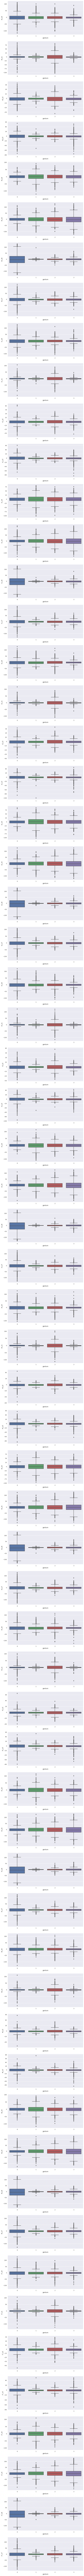

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10, 350), dpi = 80)
for r in range(0, 8):
    for s in range(0, 8):
        plt.subplot(64, 1, r*8 + (s+1))
        name = 'r' + str(r) + '_s' + str(s)
        sns.boxplot(x = "gesture", y = name, data = data)

### Określenie wartości statystycznych

In [41]:
sensors_data = data.drop(['gesture'], axis=1)
sensors_data.describe()

,r0_s0,r0_s1,r0_s2,r0_s3,r0_s4,r0_s5,r0_s6,r0_s7,r1_s0,r1_s1,...,r6_s6,r6_s7,r7_s0,r7_s1,r7_s2,r7_s3,r7_s4,r7_s5,r7_s6,r7_s7
count,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,...,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000
mean,-0.520380,-0.726837,-0.739082,-0.729748,-0.159103,-0.554890,-1.272649,-0.661843,-0.665953,-0.654222,...,-1.622452,-0.932694,-0.836958,-0.740623,-0.768710,-0.705343,-0.146686,-0.374807,-1.449306,-0.609094
std,18.566709,11.766878,4.989944,7.441675,17.850402,25.809528,25.089972,15.408896,18.123854,11.841260,...,25.293001,15.158993,18.204465,12.005206,4.969758,7.384410,17.841479,25.551082,25.259736,15.530091
min,-116.000000,-104.000000,-33.000000,-75.000000,-121.000000,-122.000000,-128.000000,-128.000000,-110.000000,-128.000000,...,-128.000000,-128.000000,-116.000000,-128.000000,-46.000000,-74.000000,-103.000000,-128.000000,-128.000000,-124.000000
25%,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-15.000000,-6.000000,-8.000000,-9.000000,-4.000000,...,-6.000000,-8.000000,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-14.000000,-6.000000,-8.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
75%,7.000000,3.000000,2.000000,3.000000,10.000000,13.000000,4.000000,6.000000,6.000000,3.000000,...,3.000000,6.000000,6.000000,3.000000,2.000000,3.000000,10.000000,13.000000,3.000000,6.000000
max,111.000000,90.000000,34.000000,55.000000,92.000000,127.000000,127.000000,126.000000,127.000000,106.000000,...,127.000000,114.000000,127.000000,105.000000,29.000000,51.000000,110.000000,127.000000,127.000000,127.000000


### Określenie poziomu wypełnienia kolumn

In [42]:
objects_with_missing_columns = data.isna().sum().sum()

print('Liczba obiektów z brakującymi kolumnami:', objects_with_missing_columns)

Liczba obiektów z brakującymi kolumnami: 0


### Określenie ilości unikalnych danych

In [43]:
unique_data_count = len(data.drop_duplicates())

print('Ilość unikalnych danych:', unique_data_count)

Ilość unikalnych danych: 11678


## Analiza korelacji między zmiennymi

Przeanalizować korelację między zmiennymi

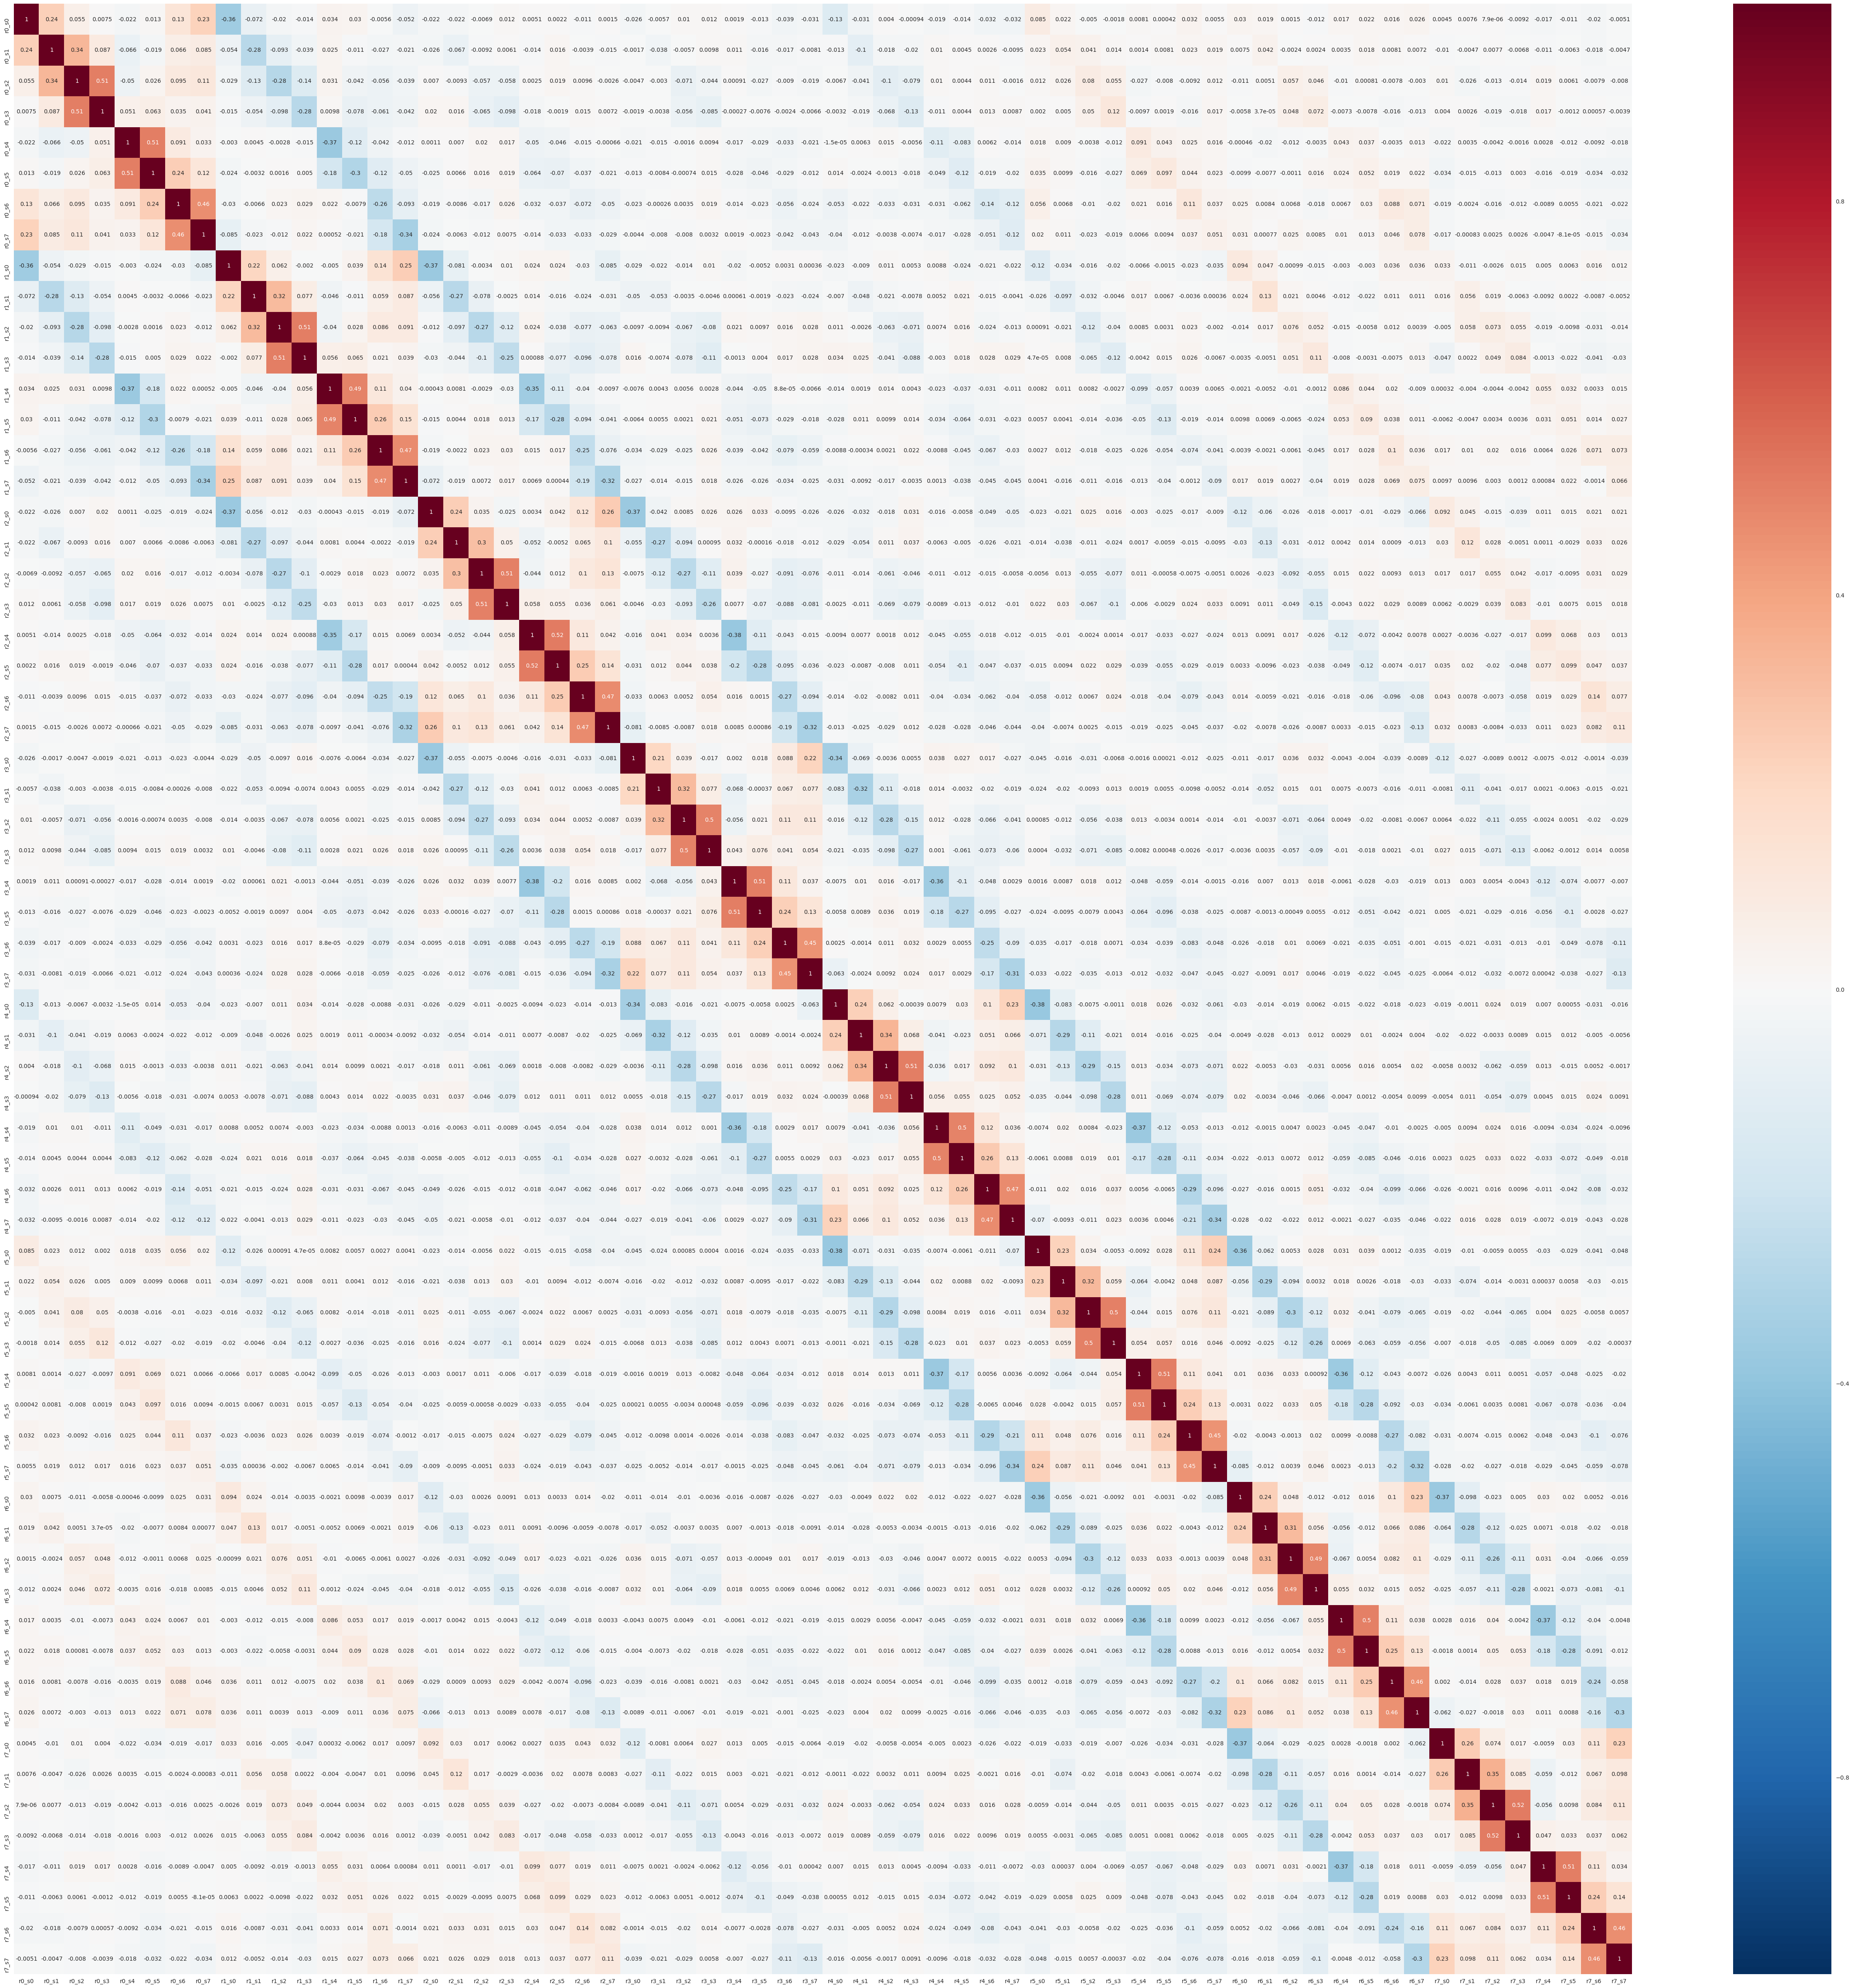

In [44]:
plt.figure(figsize = (64, 64), dpi = 100)
sns.heatmap(sensors_data.corr(), annot = sensors_data.corr())
plt.show()

## Przygotowanie danych do analizy

Dane są w pełni wypełnione dlatego nie ma potrzeby usuwania brakujących danych lub kolumn.

## Analiza podobieństwa przy pomocy algorytmów grupowania

Przeanalizować podobieństwo między danymi przy pomocy poznanych algorytmów grupowania wraz z analizą ilości grup

grupa       0  1  2  3
gesture               
0        2906  2  1  1
1        2903  0  0  0
2        2943  0  0  0
3        2922  0  0  0
grupa     0     1   2    3
gesture                   
0        19  2569  43  279
1         0  2903   0    0
2         0  2943   0    0
3         0  2922   0    0


ValueError: Unknown linkage type single.Valid options are dict_keys(['ward', 'complete', 'average'])

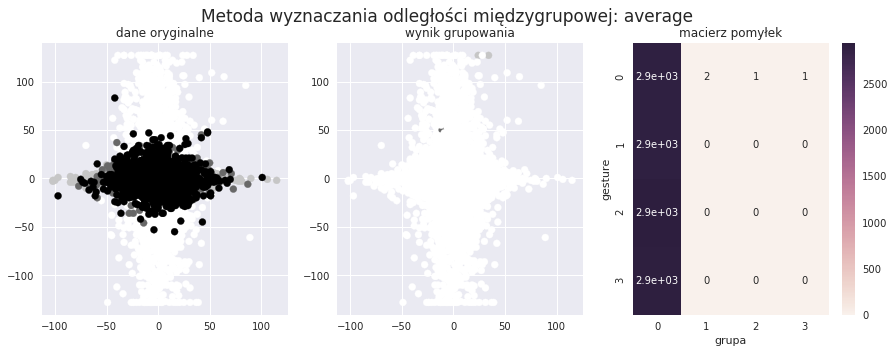

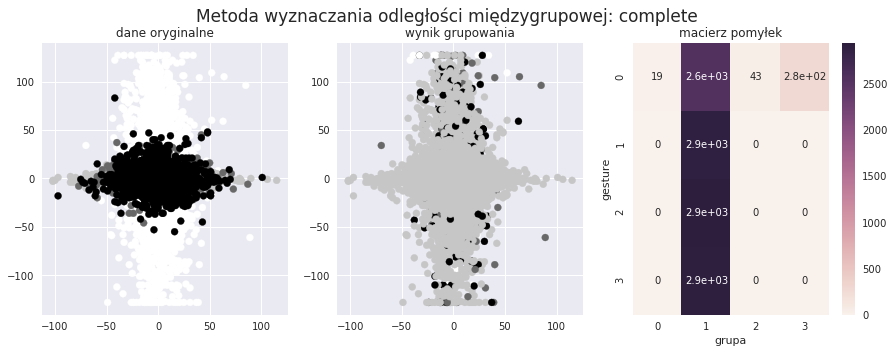

In [45]:
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from sklearn.cluster import AgglomerativeClustering

ile_grup = 4
sd_copy = sensors_data
attribute_1 = 'r5_s4'
attribute_2 = 'r1_s6'

klasa = data['gesture'].astype('category').cat.codes

for index, linkage in enumerate(('average', 'complete', 'single', 'ward')):
    model = AgglomerativeClustering(linkage=linkage, n_clusters=ile_grup)
    model.fit(sd_copy)
    grupa = model.labels_

    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    plt.scatter( x=data[attribute_1], y=data[attribute_2], c=klasa)
    plt.title('dane oryginalne')

    plt.subplot(1,3,2)
    sd_copy['grupa']= model.labels_
    plt.scatter( x=sensors_data[attribute_1], y=sd_copy[attribute_2], c=grupa)
    plt.title('wynik grupowania')

    plt.subplot(1,3,3)
    pomylki = pd.crosstab(data['gesture'], sd_copy['grupa'])
    print(pomylki)
    sns.heatmap(pomylki, annot = pomylki)
    plt.title('macierz pomyłek')
    
    plt.suptitle('Metoda wyznaczania odległości międzygrupowej: ' + linkage, size=17)

## Testowanie wybranych klasyfikatorów

Testujemy wybrane klasyfikatory pod kątem doboru ich parametrów


In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels

In [ ]:
Podział zbioru danych na argumenty i wyniki, podział na dane treningowe i testowe.

In [ ]:
x = data.drop(['gesture'], axis=1)
x = StandardScaler().fit_transform(x)
y = data['gesture']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .30, random_state=38)

In [ ]:
Wyświetlanie błędów


In [ ]:
import numpy as np

def view_confusion_matrix(y_true, y_pred, classes,title=None, cmap=plt.cm.Greens):
    if not title:
        title="Macierz błędów"
    conf_mtx = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(conf_mtx, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(conf_mtx.shape[1]),
           yticks=np.arange(conf_mtx.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Prawdziwa klasa',
           xlabel='Przewidywana klasa')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    
    thresh = conf_mtx.max() / 2.
    
    for k in range(conf_mtx.shape[0]):
        for l in range(conf_mtx.shape[1]):
            ax.text(k, l, format(conf_mtx[k, l], fmt),
                    ha="center", va="center",
                    color="white" if conf_mtx[k, l] > thresh else "black")
            
    fig.tight_layout()
    
    return ax


In [ ]:
### Klasyfikator KNN na podstawie 15 najbliższych

In [ ]:
knn = KNeighborsClassifier(15)

knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
result = knn.result(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

In [ ]:
### Klasyfikator KNN - klasyfikacja na podstawie 100 najbliższych sąsiadów

In [ ]:
knn = KNeighborsClassifier(100)

knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
result = knn.result(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

In [ ]:
### Naiwny klasyfikator bayesowski 

In [ ]:
ncb = GaussianNB()

ncb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
result = nb.result(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

In [ ]:
### Klasyfikator Drzewa Decyzyjnego bez ustawionej głębokości maksymalnej - kryterium 'gini'.

In [ ]:
dtc = DecisionTreeClassifier()

dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
result = dtc.result(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność: ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

In [ ]:
### Klasyfikator Drzewa Decyzyjnego z ustawion głębokością maksymalną - kryterium 'gini'.

In [ ]:
dtc = DecisionTreeClassifier(max_depth=25)

dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
result = dtc.result(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność: ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

In [ ]:
Klasyfikator Drzewa Decyzyjnego z ustawioną głębokością maksymalną, kryterium 'entropia'.

In [ ]:
dtc = DecisionTreeClassifier(max_depth=18, criterion='entropy')

dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
result = dtc.result(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność: ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

In [ ]:
## Wnioski

Proszę ocenić czy do poprawnej klasyfikacji należy wykorzystać wszystkie atrybuty, czy wystarczy ich podzbiór, a może należy stworzyć jakieś nowe dane w oparciu o istniejące